In [1]:
! pip install python-terrier
! pip install nlpaug
! pip install levenshtein
! pip install fast-forward-indexes

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.4/163.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 20.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 1.9 MB/s eta 0:00:00
  Created wheel for chest: filename=chest-0.2.3-py3-none-any.whl size=7611 sha256=d4ce574181c2c7af9024ff15d65f29bccc2aeb49454100f409bbaf99571bcc91
  Stored in directory: /root/.cache/pip/wheels/88/cf

In [2]:
import pyterrier as pt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyterrier.measures import nDCG, Recall, MRR
import nlpaug.augmenter.char as nac
import nlpaug.flow as naf
import Levenshtein

In [3]:
dataset_path = "irds:beir/fiqa"
dataset = pt.get_dataset(dataset_path)
testset = pt.get_dataset(dataset_path + "/test")
test_queries = testset.get_topics()

[INFO] [starting] opening zip file
[INFO] If you have a local copy of https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/17918ed23cd04fb15047f73e6c3bd9d9
[INFO] [starting] https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip
[INFO] [finished] https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip: [00:05] [17.9MB] [3.22MB/s]
[INFO] [finished] opening zip file [6.04s]                                                              
[INFO] [starting] opening zip file
[INFO] [finished] opening zip file s]


terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started (triggered by _pt_tokeniser) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


## Parameters

In [4]:
metrics = [MRR @ 10, nDCG @ 10, Recall @ 10]
metrics_names = ['RR@10', 'nDCG@10', 'R@10']
noise_levels = np.arange(0.0, 0.5, 0.1)

cer_b_1 = np.arange(0.0, 1, 0.1)
cer_b_2 = np.arange(0.0, 0.4, 0.04)

wer_b_1 = np.arange(0.0, 0.4, 0.04)
wer_b_2 = np.arange(0.0, 1, 0.1)

noise_combinations = [
    {"keyboard": 1.0},  # Keyboard noise
    {"sub": 1.0, "ins": 0.0, "del": 0.0},  # Only substitution
    # {"sub": 0.0, "ins": 1.0, "del": 0.0},  # Only insertion
    # {"sub": 0.0, "ins": 0.0, "del": 1.0},  # Only deletion
    {"sub": 0.5, "ins": 0.5, "del": 0.0},  # Substitution + Insertion
    {"sub": 0.5, "ins": 0.0, "del": 0.5},  # Substitution + Deletion
    # {"sub": 0.0, "ins": 0.5, "del": 0.5},  # Insertion + Deletion
    {"sub": 0.33, "ins": 0.33, "del": 0.33},  # Equal mix
]

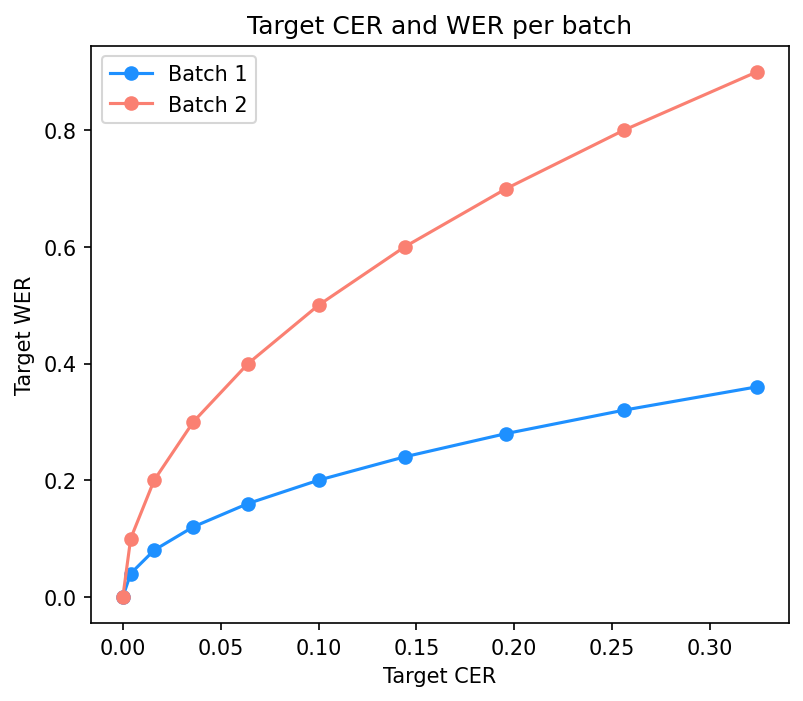

In [5]:
# Plot CER and WER values

plt.figure(figsize=(6, 5), dpi=150)

plt.plot(cer_b_1*wer_b_1, wer_b_1, 'o-', label="Batch 1", color="dodgerblue")
plt.plot(cer_b_2*wer_b_2, wer_b_2, 'o-', label="Batch 2", color="salmon")
# plt.plot(cer_values, wer_values, 'o-', label="Batch 3", color="mediumseagreen")

plt.xlabel("Target CER")
plt.ylabel("Target WER")
plt.title("Target CER and WER per batch")
plt.legend()

plt.grid(False)
plt.show()

In [6]:
def calc_cer(reference: str, hypothesis: str) -> float:
    """
    Compute the Character Error Rate (CER) between a reference sentence and a hypothesis.
    
    Parameters:
        reference (str): The ground truth sentence.
        hypothesis (str): The predicted sentence.

    Returns:
        float: CER value (lower is better).
    """
    distance = Levenshtein.distance(reference, hypothesis)
    return distance / max(1, len(reference))  # Avoid division by zero

# Example usage
ref = "hello world"
hyp = "helo wrld"
print(f"CER: {calc_cer(ref, hyp):.4f}")

CER: 0.1818


## Creates the model retrievers

In [7]:
from pathlib import Path

indexer = pt.IterDictIndexer(
    str(Path.cwd()),  # this will be ignored
    type=pt.index.IndexingType.MEMORY,
    fields=["text"]
)
index_ref = indexer.index(dataset.get_corpus_iter())

[INFO] [starting] building docstore
[INFO] [starting] opening zip file                                              
[INFO] [finished] opening zip file s]                                        
docs_iter: 100%|██████████████████████| 57638/57638 [00:01<00:00, 38231.23doc/s]
[INFO] [finished] docs_iter: [00:01] [57638doc] [38215.14doc/s]
[INFO] [finished] building docstore [1.51s]
beir/fiqa documents: 100%|██████████| 57638/57638 [00:18<00:00, 3128.23it/s]


In [8]:
from fast_forward.index import OnDiskIndex, Mode
from fast_forward.util import Indexer
from fast_forward.util.pyterrier import FFScore
from fast_forward.encoder import TASBEncoder
import torch

def docs_iter():
    for d in dataset.get_corpus_iter():
        yield {"doc_id": d["docno"], "text": d["text"]}

def create_ffs_transformer(index_path: Path, docs_iter):
    """
    Creates an FFScore object using a dense bi-encoder (TAS-B) with an on-disk index.

    - Initializes a query and document encoder using TASBEncoder.
    - Builds a dense index with documents provided by `docs_iter()`.
    - Saves the index to disk and loads it for scoring.

    :param index_path: Path to store or load the on-disk dense index.
    :param docs_iter: A callable that returns an iterable of documents in dict format (e.g., [{"docno": ..., "text": ...}, ...]).
    :return: An FFScore object that can be used for re-ranking or retrieval with dense vectors.
    """
    q_encoder = d_encoder = TASBEncoder(
        device="cuda:0" if torch.cuda.is_available() else "cpu"
    )
    
    ff_index_path = index_path
    ff_index_path.parent.mkdir(exist_ok=True, parents=True)
    ff_index = OnDiskIndex(
        ff_index_path,
        query_encoder=q_encoder,
        mode=Mode.MAXP,
    )

    Indexer(ff_index, d_encoder, batch_size=8).from_dicts(docs_iter())

    ff_index = OnDiskIndex.load(
        index_path,
        query_encoder=q_encoder,
        mode=Mode.MAXP,
    )

    return FFScore(ff_index)

ff_score = create_ffs_transformer(Path.cwd() / "neural_index" / "ffindex_fiqa_tasb.h5", docs_iter)

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/262k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

0it [00:00, ?it/s]
99it [00:01, 82.96it/s]0%|          | 90/57638 [00:01<11:33, 83.02it/s]
108it [00:01, 83.23it/s]%|          | 99/57638 [00:01<11:33, 83.02it/s]
117it [00:01, 82.87it/s]%|          | 108/57638 [00:01<11:31, 83.21it/s]
126it [00:01, 83.12it/s]%|          | 117/57638 [00:01<11:33, 82.91it/s]
135it [00:02, 82.95it/s]%|          | 126/57638 [00:01<11:31, 83.14it/s]
144it [00:02, 69.25it/s]%|          | 135/57638 [00:02<11:33, 82.97it/s]
160it [00:02, 77.71it/s]%|          | 144/57638 [00:02<13:50, 69.26it/s]
168it [00:02, 76.83it/s]%|          | 160/57638 [00:02<12:19, 77.70it/s]
184it [00:02, 79.03it/s]%|          | 168/57638 [00:02<12:27, 76.83it/s]
192it [00:02, 78.06it/s]%|          | 184/57638 [00:02<12:07, 79.01it/s]
208it [00:02, 86.53it/s]%|          | 192/57638 [00:02<12:15, 78.07it/s]
224it [00:03, 93.31it/s]%|          | 208/57638 [00:02<11:03, 86.53it/s]
248it [00:03, 103.48it/s]|          | 224/57638 [00:03<10:15, 93.28it/s]
264it [00:03, 104.88it/s]|        

In [9]:
from fast_forward.util.pyterrier import FFInterpolate

bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")

def create_reranker(retriever_to_rerank, ff_score):
    """
    Creates a re-ranking pipeline by combining an initial retriever, a re-ranking model (e.g., a neural scorer),
    and an interpolation step to blend BM25 and re-ranker scores.

    :param retriever_to_rerank: PyTerrier retriever component (e.g., BM25) used to retrieve initial candidate documents.
    :param ff_score: A re-ranking model or transformer (e.g., a learned model like MonoT5 or a feature function).
    :return: A PyTerrier pipeline that retrieves top 1000 documents, reranks them with ff_score, 
    and interpolates scores.
    """
    candidates = (retriever_to_rerank % 5)(test_queries)
    re_ranked = ff_score(candidates)
    ff_int = FFInterpolate(alpha=0.5)
    ff_int(re_ranked)
    return retriever_to_rerank % 1000 >> ff_score >> ff_int

neural_reranker = create_reranker(bm25, ff_score)

retrievers = {
    # "TF-IDF": tfidf,
    "BM25": bm25,
    "re-ranker": neural_reranker,
    # "SparseColBERT": sparse_colbert,
}

21:04:09.469 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


## Runs the experiments

In [10]:
def create_augmenter(noise_config, word_aug, cer_aug):  
    if "keyboard" in noise_config:
        return nac.KeyboardAug(aug_word_p=word_aug, aug_char_p=cer_b_1[index], include_special_char=False, aug_word_max=500000)
    else:
        return naf.Sequential([
            nac.RandomCharAug(action="substitute", aug_word_p=word_aug, aug_char_p=(noise_config["sub"] * cer_aug), spec_char=""),
            nac.RandomCharAug(action="insert", aug_word_p=word_aug, 
                              aug_char_p=(noise_config["ins"] * cer_aug), spec_char=""),
            nac.RandomCharAug(action="delete", aug_word_p=word_aug, 
                              aug_char_p=(noise_config["del"] * cer_aug), spec_char="")
        ])

def add_query_noise(queries: pd.DataFrame, noise_metric) -> (pd.DataFrame, int):
    actual_cer = 0.0
    noisy_queries_list = []
    for _, row in queries.iterrows():
        noisy_query = noise_metric.augment(row['query'])
        noisy_query = " ".join(noisy_query) if isinstance(noisy_query, list) else noisy_query
        noisy_queries_list.append({'qid': row['qid'], 'query': noisy_query})

        actual_cer += calc_cer(row['query'], noisy_query)

    noisy_queries_df = pd.DataFrame(noisy_queries_list)
    noisy_queries_df["qid"] = noisy_queries_df["qid"].astype(str)

    actual_cer = actual_cer / len(queries)
    return noisy_queries_df, actual_cer

In [11]:
from tqdm import tqdm
# tfidf = pt.terrier.Retriever(index_ref, wmodel="TF_IDF")

results_batch_1 = []
results_batch_2 = []

for noise_config in tqdm(noise_combinations):
    # Batch 1
    results_for_augmentor_1 = []

    for model_name, retriever in retrievers.items():
        results_for_model = []

        for index in range(len(cer_b_1)):
            aug = create_augmenter(noise_config, wer_b_1[index], cer_b_1[index])
            noisy_queries_df, actual_cer = add_query_noise(test_queries, aug)

            eval_result = pt.Experiment(
                [retriever],
                noisy_queries_df,
                testset.get_qrels(),
                eval_metrics=metrics
            )

            results_for_model.append({
                "noise_level": actual_cer,
                "results": eval_result
            })

        results_for_augmentor_1.append({
            "model_name": model_name,
            "results": results_for_model
        })

    results_batch_1.append({
        "noise_config": noise_config,
        "results": results_for_augmentor_1
    })

    # Batch 2
    results_for_augmentor_2 = []

    for model_name, retriever in retrievers.items():

        results_for_model = []

        for index in range(len(cer_b_2)):
            aug = create_augmenter(noise_config, wer_b_2[index], cer_b_2[index])
            noisy_queries_df, actual_cer = add_query_noise(test_queries, aug)

            eval_result = pt.Experiment(
                [retriever],
                noisy_queries_df,
                testset.get_qrels(),
                eval_metrics=metrics
            )

            results_for_model.append({
                "noise_level": actual_cer,
                "results": eval_result
            })

        results_for_augmentor_2.append({
            "model_name": model_name,
            "results": results_for_model
        })

    results_batch_2.append({
        "noise_config": noise_config,
        "results": results_for_augmentor_2
    })


100%|██████████| 5/5 [1:01:20<00:00, 736.01s/it]


## Plots results

In [12]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def get_plot_style(model_name):
    if model_name == 're-ranker':
        return '^', ':'
    return 'o', '-'

def add_legend(fig):
    proxy_lines = [
        Line2D([0], [0], color='orange', linestyle='-', linewidth=2),
        Line2D([0], [0], color='g', linestyle='-', linewidth=2),
        Line2D([0], [0], color='b', linestyle='-', linewidth=2),
        Line2D([0], [0], color='black', marker='o', linestyle='-', markersize=6),
        Line2D([0], [0], color='black', marker='^', linestyle='--', markersize=6)
    ]
    fig.legend(proxy_lines, ['MRR @ 10', 'nDCG @ 10', 'Recall @ 10', 'BM25', 'Re-ranker'],
               loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=3, fontsize=12, frameon=True)

def plot_single_noise_config(ax, noise_config_data, metrics_names, colors):
    from matplotlib.ticker import FuncFormatter

    def format_yaxis(value, _): return f"{value:.2f}"

    noise_config = noise_config_data['noise_config']
    results = noise_config_data['results']

    for model_data in results:
        model_name = model_data['model_name']
        model_results = model_data['results']

        for idx, metric in enumerate(metrics_names):
            noise_levels = [r['noise_level'] for r in model_results]
            metric_values = [r['results'][metric] for r in model_results]
            marker, line_style = get_plot_style(model_name)

            ax.plot(noise_levels, metric_values, label=f"{model_name} - {metric}",
                    linestyle=line_style, color=colors[idx], marker=marker,
                    markersize=6, linewidth=2)

    ax.set_xlabel('Real CER', fontsize=12)
    ax.set_ylabel('Performance', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_ylim(0, 0.4)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.yaxis.set_major_formatter(FuncFormatter(format_yaxis))

    if "keyboard" in noise_config:
        ax.set_title("Keyboard Noise", fontsize=14, fontweight='bold')
    else:
        ax.set_title(f"Noise Config (sub={noise_config['sub']}, ins={noise_config['ins']}, del={noise_config['del']})",
                     fontsize=12, fontweight='bold')


def plot_experiment_results(batch_to_plot):
    # Use a modern style
    plt.style.use('seaborn-v0_8-colorblind')
    
    colors = ['b', 'g', 'orange']
    
    # Function to format y-axis values
    def format_yaxis(value, _):
        return f"{value:.2f}"
    
    # Create a 2-row, 3-column figure for subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()  # Flatten to iterate easily
    
    num_plots = min(len(batch_to_plot), len(axes))
    
    for ax, noise_config_data in zip(axes, batch_to_plot):
        plot_single_noise_config(ax, noise_config_data, metrics_names, colors)
    
    add_legend(fig)
    
    # Remove unused subplots
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit legend
    plt.show()

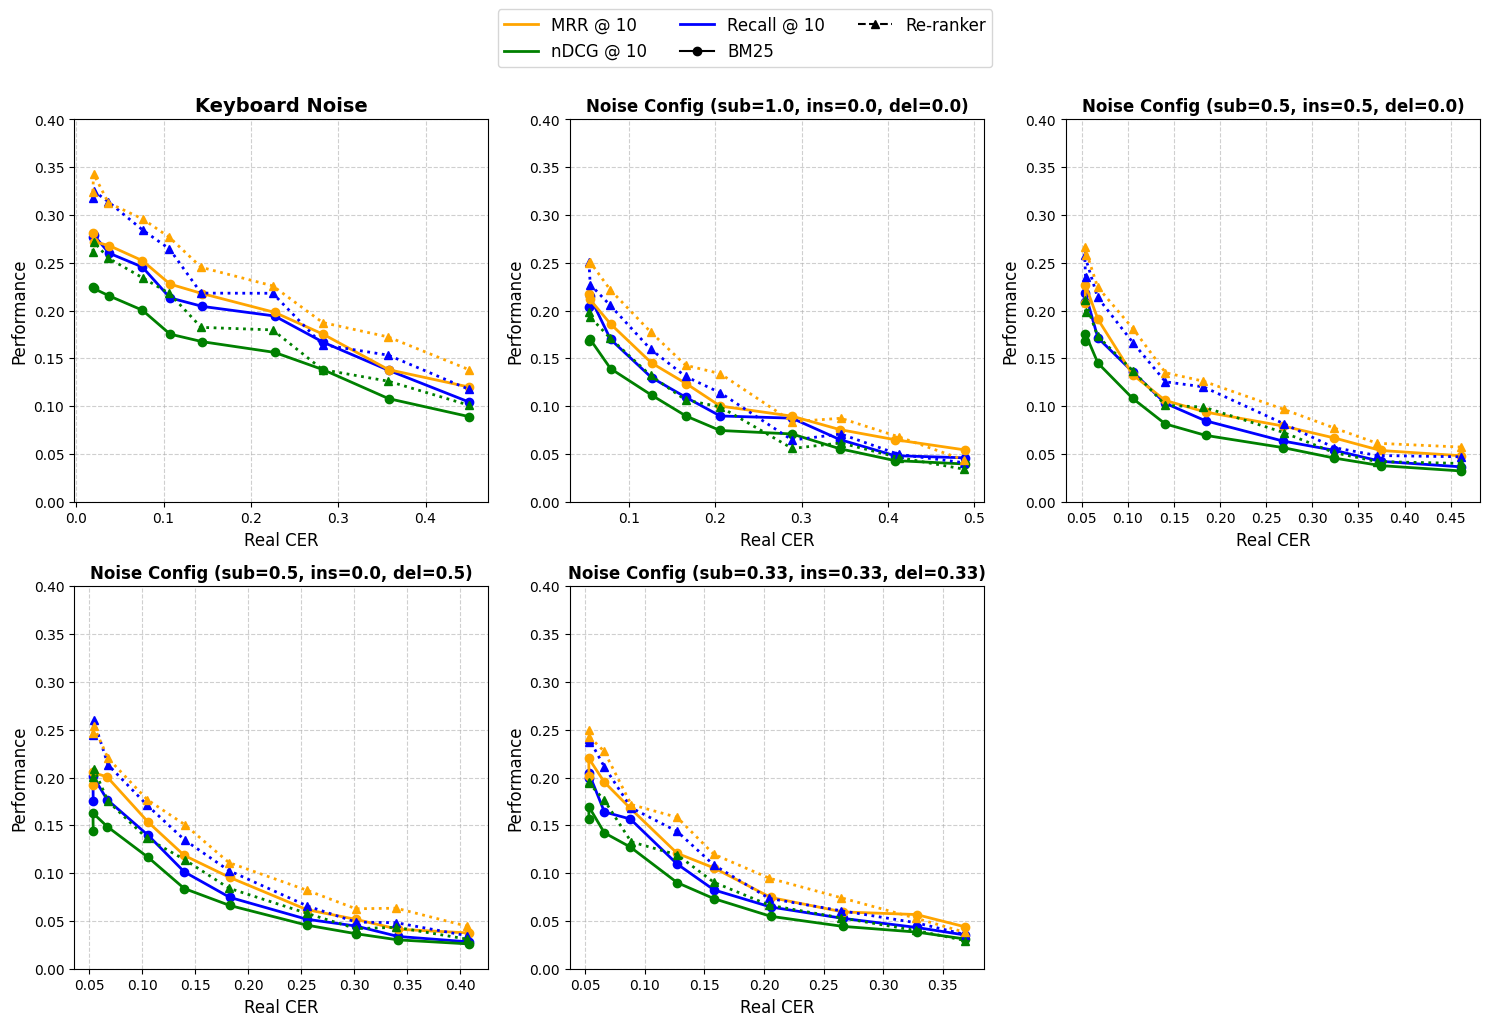

In [13]:
plot_experiment_results(results_batch_1)

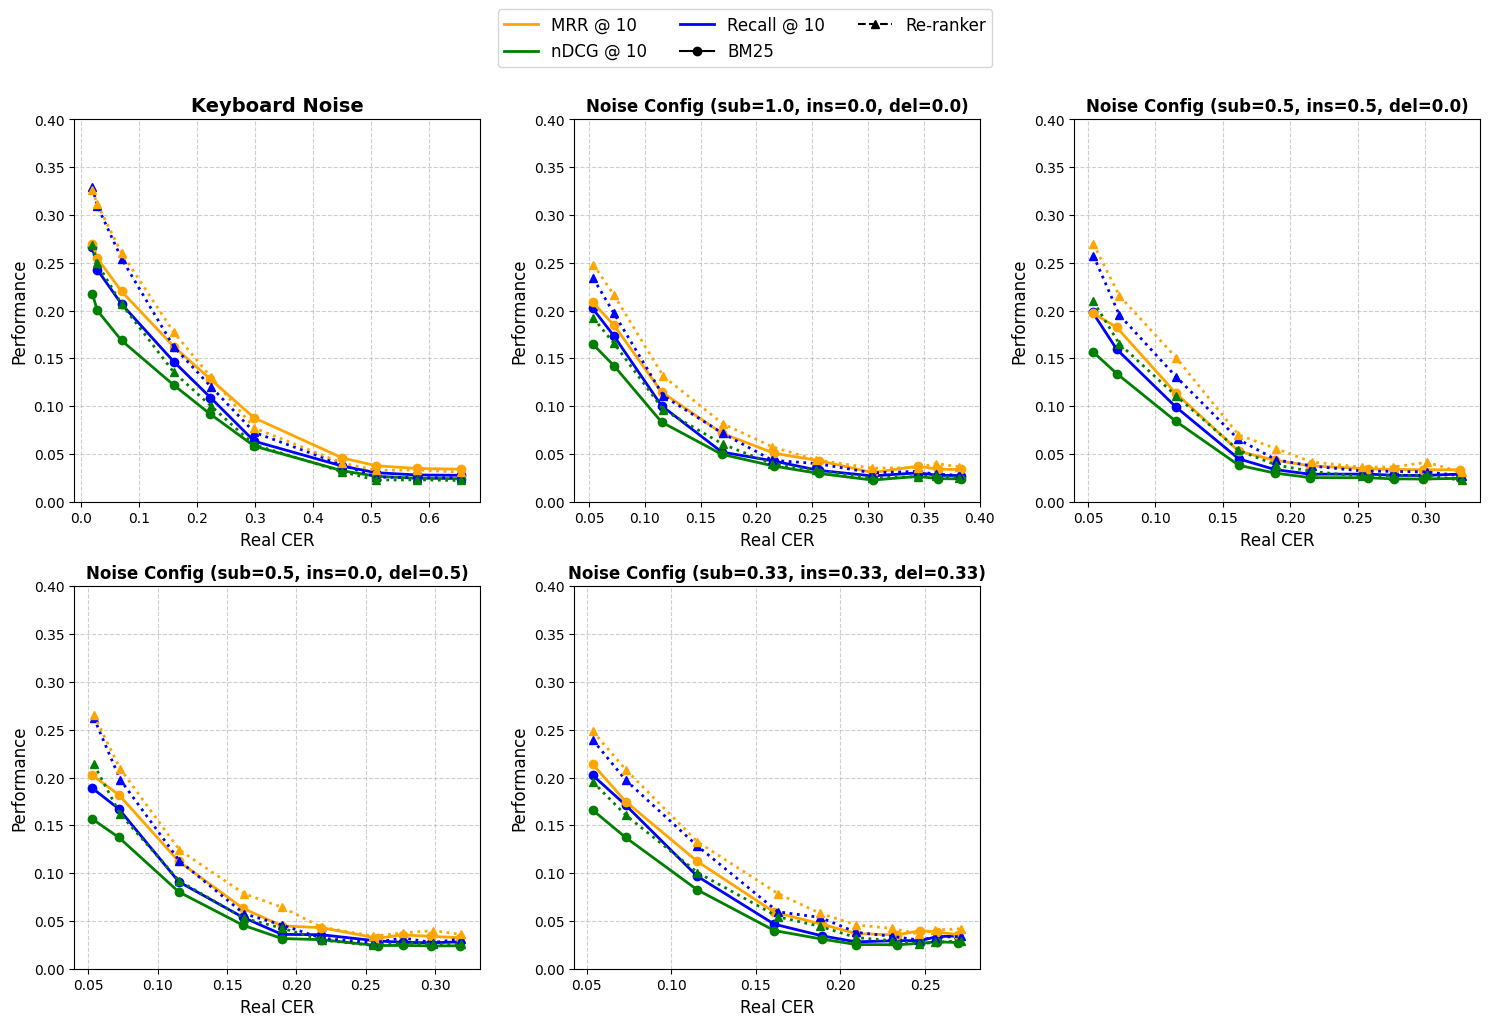

In [14]:
plot_experiment_results(results_batch_2)